In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette('bright')
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')
from scipy import fft
from scipy.stats import wasserstein_distance

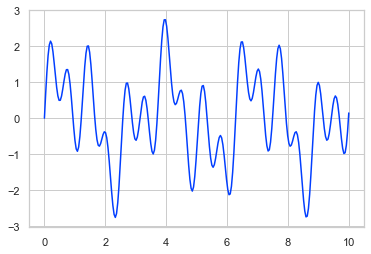

In [85]:
from scipy import signal
import math
x = np.linspace(0, 10, 250)
y = np.sin(2*x)+np.sin(5*x) + np.sin(10*x) 
plt.plot(x, y)
plt.show()

In [86]:
#x = np.arange(1, 31, 1)
signal_3 = pd.DataFrame(zip(x,y),columns=['Time','Value'])

# FFT regeneration

In [29]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    #freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_img
freq_ampli3i = freq(signal_3)

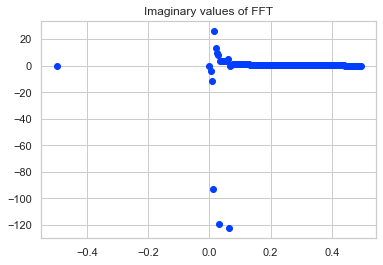

In [30]:
#sns.lineplot(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.xlim(0, 0.2)
#plt.title('Real values of FFT')
#plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

In [31]:
np.shape(freq_ampli3i)

(126, 2)

In [32]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [33]:
#best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      

In [34]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=23) 

WEIGHTS - [0.02385688 0.00793651 0.00793651 0.00793651 0.00793651 0.00793651
 0.02433243 0.21148052 0.00793651 0.00793651 0.00793651 0.10826847
 0.00793651 0.00793651 0.00793651 0.00793651 0.00793651 0.13654212
 0.11873033 0.00793651 0.02328662 0.14027969 0.10211182] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 8.00158920e-02  1.00573017e+00]
 [ 3.20000000e-02 -1.19212028e+02]
 [ 2.00000000e-02  1.31188933e+01]
 [ 1.20000000e-02 -9.25222124e+01]
 [ 1.60000000e-02  2.62250298e+01]
 [ 8.00000000e-03 -1.19499188e+01]
 [ 4.40123525e-02  3.72983333e+00]
 [ 4.44441005e-01  6.62926106e-02]
 [ 2.80000000e-02  8.14635572e+00]
 [ 4.00000000e-03 -4.01165216e+00]
 [ 6.40000000e-02 -1.22529356e+02]
 [ 2.33641479e-01  4.11470308e-01]
 [ 2.40000000e-02  9.41335471e+00]
 [ 6.00000000e-02  4.89414485e+00]
 [-5.00000000e-01  0.00000000e+00]
 [ 6.80000000e-02 -5.25923102e-01]
 [ 7.20000000e-02  5.99901751e-01]
 [ 1.20486099e-01  8.87537481e-01]
 [ 2.90885140e-01  2.87

In [35]:
#Sampling
#z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

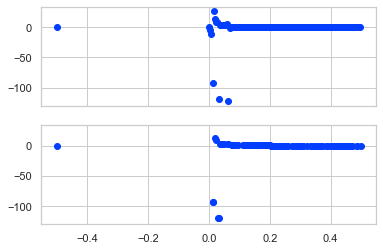

In [36]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [37]:
#sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [38]:
#sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
#sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [39]:
f = fftpack.fftfreq(250)       
sd = dict(zip(np.round(f,3),np.zeros(len(f))))
#sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))
#samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [40]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: 0.0,
 0.008: 0.0,
 0.012: -185.04308961062213j,
 0.016: 0.0,
 0.02: 0.0,
 0.024: 9.412882215861488j,
 0.028: 0.0,
 0.032: -238.4232580042671j,
 0.036: 3.678579311846262j,
 0.04: 0.0,
 0.044: 0.0,
 0.048: 7.377084564886258j,
 0.052: 0.0,
 0.056: 0.0,
 0.06: 0.0,
 0.064: 3.6932902622469257j,
 0.068: 0.0,
 0.072: 0.0,
 0.076: 1.8935439487962036j,
 0.08: 0.0,
 0.084: 1.1221077224754386j,
 0.088: 0.0,
 0.092: 0.0,
 0.096: 1.0331253328960373j,
 0.1: 0.0,
 0.104: 0.0,
 0.108: 0.0,
 0.112: 0.9457445365839399j,
 0.116: 1.836971326538395j,
 0.12: 1.7951124425057219j,
 0.124: 0.0,
 0.128: 0.0,
 0.132: 0.8095251021728465j,
 0.136: 0.7964881638303171j,
 0.14: 0.0,
 0.144: 0.735794504391643j,
 0.148: 0.7127510879488015j,
 0.152: 0.0,
 0.156: 0.6506708243701438j,
 0.16: 0.0,
 0.164: 0.6524228881509544j,
 0.168: 0.6419860043946143j,
 0.172: 0.0,
 0.176: 1.196656330111947j,
 0.18: 0.5754346726429506j,
 0.184: 0.5686310206107476j,
 0.188: 1.6513402844645069j,
 0.192: 0.0,
 0.196: 0.51

In [41]:
value = list(sd.values())

# Final IFFT

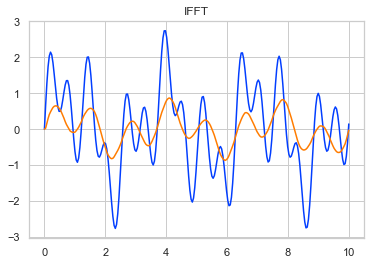

In [42]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Log FFT regeneration

In [71]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    #freq_ampli_real = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].real),columns=['Freq','Ampli'])
    freq_ampli_img = pd.DataFrame(zip(f[:N//2+1],yf[:N//2+1].imag),columns=['Freq','Ampli'])
    return freq_ampli_img
freq_ampli3i = freq(signal_3)

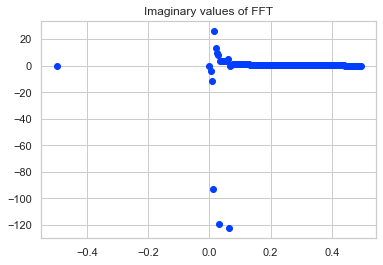

In [72]:
#sns.lineplot(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.xlim(0, 0.2)
#plt.title('Real values of FFT')
#plt.show()
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.title('Imaginary values of FFT')
plt.show()

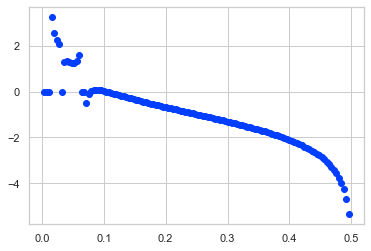

In [73]:
#freq_ampli3['Ampli'] = np.log(freq_ampli3["Ampli"])
#freq_ampli3 = freq_ampli3.loc[freq_ampli3['Ampli'] != float('-inf')]
#freq_ampli3 = freq_ampli3.dropna()
#plt.scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
freq_ampli3i['Ampli'] = np.log(freq_ampli3i["Ampli"])
freq_ampli3i = freq_ampli3i.loc[freq_ampli3i['Ampli'] != float('-inf')]
freq_ampli3i = freq_ampli3i.fillna(0)
plt.scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
plt.show()

In [74]:
np.shape(freq_ampli3i)

(124, 2)

In [75]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [76]:
#best_gmm0 = GMM_fit(freq_ampli3)                        # GMM on real part of FFT data
best_gmm0i = GMM_fit(freq_ampli3i)                      # GMM on imaginary part of FFT data

In [77]:
'''print(best_gmm0, '\n')
print('WEIGHTS -', best_gmm0.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')'''

"print(best_gmm0, '\n')\nprint('WEIGHTS -', best_gmm0.weights_, '\n')\nprint('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0.means_, '\n')"

In [78]:
print(best_gmm0i, '\n')
print('WEIGHTS -', best_gmm0i.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n',best_gmm0i.means_, '\n')

GaussianMixture(n_components=7) 

WEIGHTS - [0.06572378 0.16156141 0.10764126 0.10788428 0.3302416  0.07430581
 0.15264185] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 0.48165925 -4.02148501]
 [ 0.13312512 -0.21840154]
 [ 0.04465178  1.41768356]
 [ 0.43861    -2.65477362]
 [ 0.25388674 -1.02133025]
 [ 0.0508792   0.02222937]
 [ 0.3739837  -1.87530307]] 



In [113]:
#Sampling
#z1,_ = best_gmm0.sample(126)
z1i,_ = best_gmm0i.sample(126)

In [114]:
'''fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])
#plt.show()
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()'''

"fig, ax = plt.subplots(2, sharex='all', sharey='all')\nax[0].scatter(freq_ampli3['Freq'], freq_ampli3['Ampli'])\n#plt.show()\nax[1].scatter(z1[:, 0], z1[:, 1])\nplt.show()"

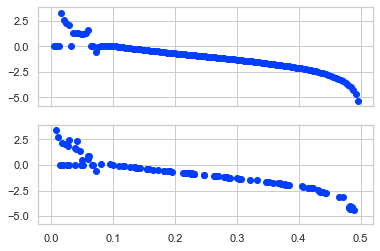

In [115]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(freq_ampli3i['Freq'], freq_ampli3i['Ampli'])
#plt.show()
ax[1].scatter(z1i[:, 0], z1i[:, 1])
plt.show()

In [116]:
#print('Real: ', wasserstein_distance(freq_ampli3['Ampli'], z1[:, 1]))
#print('Imag: ', wasserstein_distance(freq_ampli3i['Ampli'], z1i[:, 1]))

In [117]:
z1i[:, 1] = np.exp(z1i[:, 1])

In [118]:
'''plt.figure(figsize=(20,10))
sns.distplot(freq_ampli3['Ampli'], kde = True)
sns.distplot(z1[:, 1], kde = True)
#plt.ylim(0.0, 0.2)
plt.show()'''

"plt.figure(figsize=(20,10))\nsns.distplot(freq_ampli3['Ampli'], kde = True)\nsns.distplot(z1[:, 1], kde = True)\n#plt.ylim(0.0, 0.2)\nplt.show()"

In [119]:
#sample_1 = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns=['Freq','Ampli'])           
sample_1i = pd.DataFrame(zip(z1i[:,0],z1i[:,1]),columns=['Freq','Ampli'])

In [120]:
#sample_1 = sample_1.sort_values(by=['Freq'],ascending=True)     
#sample_1 = sample_1[sample_1.Freq > 0]                           
sample_1i = sample_1i.sort_values(by=['Freq'],ascending=True)
sample_1i = sample_1i[sample_1i.Freq > 0]                        

In [121]:
#sample_1 = sample_1[(sample_1.Ampli>1) | (sample_1.Ampli<-1)]
#sample_1i = sample_1i[(sample_1i.Ampli>1) | (sample_1i.Ampli<-1)]

In [157]:
f = fftpack.fftfreq(250)                                    # The frequency corresponding to each value in FFT is stored in 'f'

In [123]:
sd = dict(zip(np.round(f,3),np.zeros(len(f))))

In [124]:
#sample_1.Freq = sample_1.Freq.apply(lambda x:round(x,3))       
sample_1i.Freq = sample_1i.Freq.apply(lambda x:round(x,3))

In [125]:
#samp_1 = dict(zip(sample_1.Freq,sample_1.Ampli))
samp_1i = dict(zip(sample_1i.Freq,sample_1i.Ampli))

In [126]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.001 in sd:
        sd[i+0.001] = samp_1[i]
        sd[-(i+0.001)] = samp_1[i]
    elif i-0.001 in sd:
        sd[i-0.001] = samp_1[i]
        sd[-(i-0.001)] = samp_1[i]
sd

'for i in samp_1.keys():\n    if i in sd:\n        sd[i] = samp_1[i]\n        sd[-i] = samp_1[i]\n    elif i+0.001 in sd:\n        sd[i+0.001] = samp_1[i]\n        sd[-(i+0.001)] = samp_1[i]\n    elif i-0.001 in sd:\n        sd[i-0.001] = samp_1[i]\n        sd[-(i-0.001)] = samp_1[i]\nsd'

In [127]:
for i in samp_1i.keys():
    if i in sd:
        sd[i] = complex(sd[i],samp_1i[i])
        sd[-i] = complex(sd[i],-(samp_1i[i]))
    elif i+0.001 in sd:
        sd[i+0.001] = complex(sd[i+0.001],samp_1i[i])
        sd[-(i+0.001)] = complex(sd[i+0.001],-(samp_1i[i]))
    elif i-0.001 in sd:
        sd[i-0.001] = complex(sd[i-0.001],samp_1i[i])
        sd[-(i-0.001)] = complex(sd[i-0.001],-(samp_1i[i]))
sd

{0.0: 0.0,
 0.004: 0.0,
 0.008: 30.724436869962258j,
 0.012: 14.879335040014107j,
 0.016: 9.756895585083686j,
 0.02: 0.9839603382942789j,
 0.024: 14.917463495105203j,
 0.028: 7.521131980282708j,
 0.032: 0.0,
 0.036: 0.0,
 0.04: 20.205737474370984j,
 0.044: 0.0,
 0.048: 1.0044992058371274j,
 0.052: 1.013416629990353j,
 0.056: 0.0,
 0.06: 6.584482976117736j,
 0.064: 0.0,
 0.068: 1.01961689934885j,
 0.072: 0.5298327013427195j,
 0.076: 0.0,
 0.08: 1.054543303498209j,
 0.084: 0.0,
 0.088: 0.0,
 0.092: 0.0,
 0.096: 1.0514267307154082j,
 0.1: 1.02427881804425j,
 0.104: 0.0,
 0.108: 0.0,
 0.112: 0.0,
 0.116: 1.8166536025341768j,
 0.12: 0.0,
 0.124: 0.0,
 0.128: 0.8428153675186215j,
 0.132: 0.0,
 0.136: 1.5731890068892607j,
 0.14: 1.5413160097672922j,
 0.144: 0.7467133903241809j,
 0.148: 0.0,
 0.152: 0.0,
 0.156: 0.6862190969046318j,
 0.16: 0.0,
 0.164: 0.6416226564279303j,
 0.168: 0.0,
 0.172: 0.6135627781560254j,
 0.176: 0.0,
 0.18: 0.0,
 0.184: 0.0,
 0.188: 0.5398976609480131j,
 0.192: 0.533

In [128]:
value = list(sd.values())

# Final IFFT 

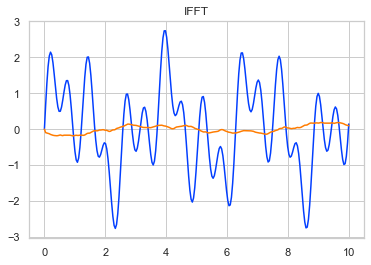

In [129]:
ift = fft.ifft(value)
plt.title('IFFT')
plt.plot(signal_3['Time'], signal_3['Value'])
plt.plot(x,ift)

# Cepstrum

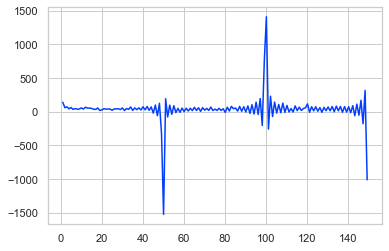

In [82]:
frame_size = signal_3.shape[0]
Fs = 1
dt = 1/Fs
freq_vector = np.fft.rfftfreq(frame_size, d=dt)
y = np.array(signal_3['Value'])
yf = fftpack.fft(y)
yf1 = yf[yf != 0]
quefrency = np.fft.rfftfreq(np.log(yf1).size,freq_vector[1] - freq_vector[0])
cepstrum = np.fft.rfft(np.log(np.abs(yf1)))
cep = pd.DataFrame(zip(quefrency,cepstrum.real),columns=['Quefrency','Cepstrum'])
cep = cep.iloc[1:,:]
plt.plot(cep.Quefrency,cep.Cepstrum)

In [32]:
cep

,Quefrency,Cepstrum
1,1.0,114.305160
2,2.0,51.866648
3,3.0,31.134172
4,4.0,20.855389
5,5.0,14.777179
...,...,...
121,121.0,-17.096970
122,122.0,-17.888085
123,123.0,-18.495206
124,124.0,-18.877692


In [7]:
dfx = cep
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [8]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

GaussianMixture(n_components=21) 

WEIGHTS - [0.06403001 0.06399746 0.03999957 0.05778153 0.008      0.06397664
 0.008      0.10110621 0.06940112 0.0560015  0.02399999 0.05603561
 0.05564975 0.07188014 0.008      0.05206164 0.05600269 0.04805859
 0.0480175  0.016      0.03200007] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[ 77.49303504  -1.61104119]
 [ 18.50715647   0.20354526]
 [111.99981828  -8.69209568]
 [ 52.22668614  -0.7620454 ]
 [  1.         114.30516046]
 [ 92.49474117  -2.79079875]
 [  3.          31.13417224]
 [ 35.79520976  -0.48000394]
 [ 60.15872886  -0.95315071]
 [117.99988011 -14.10095839]
 [  6.9999996    8.31940089]
 [ 99.99486707  -3.94418997]
 [ 25.98774726  -0.30178309]
 [ 68.99868361  -1.23521734]
 [  2.          51.86664784]
 [ 45.3377002   -0.62977248]
 [ 84.99588105  -2.08286957]
 [ 11.50430366   2.55430695]
 [106.49849851  -5.77539688]
 [  4.5         17.81628392]
 [123.49999437 -18.56733628]] 



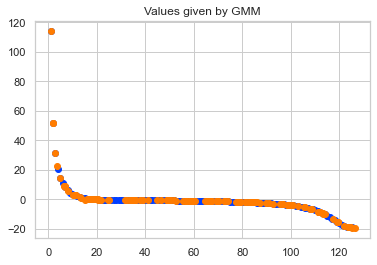

In [9]:
z3,_ = best_gmm3.sample(125)
plt.title('Actual data')
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
#plt.show()
plt.title('Values given by GMM')
plt.scatter(z3[:,0],z3[:,1])
plt.show()

In [47]:
wasserstein_distance(cep['Cepstrum'], z3[:, 1])

3.6441915978850314

In [48]:
def dim(df):
    d = []
    for i,j in df.values.tolist():
        for k in range(round(j)):
            d.append(i)
    return d
list(np.array(cep))
c = dim(cep)
cep.sort_values(by=['Cepstrum'],ascending = False)
np.shape(c)

(730,)

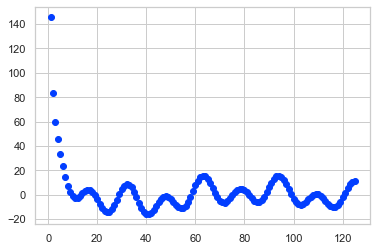

<AxesSubplot:ylabel='Density'>

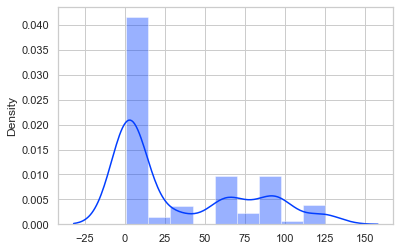

In [49]:
plt.scatter(cep['Quefrency'], cep['Cepstrum'])
plt.show()
sns.distplot(c)

In [50]:
c = np.array(c).reshape(-1,1)
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 50)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm
best_gmm22 = GMM_fit(c)

In [51]:
print(best_gmm22, '\n')
print('WEIGHTS -', best_gmm22.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm22.means_, '\n')

GaussianMixture(covariance_type='spherical', n_components=49) 

WEIGHTS - [0.04657534 0.02054795 0.0136985  0.01506849 0.01232877 0.006849
 0.11369863 0.00547926 0.01917808 0.01643836 0.0109589  0.00136986
 0.2        0.01369863 0.02054795 0.08219178 0.0109589  0.00821918
 0.06164384 0.00684932 0.00958904 0.03287671 0.01232877 0.00273973
 0.02054795 0.02054795 0.00547945 0.01643836 0.02054795 0.02191781
 0.01780822 0.01780822 0.01506849 0.01232877 0.0082195  0.00821918
 0.0109589  0.00958917 0.00684931 0.00547965 0.00273973 0.00684932
 0.00547945 0.00547945 0.00410959 0.00410959 0.00273973 0.00410959
 0.00273973] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[  5.        ]
 [ 93.        ]
 [ 66.        ]
 [124.        ]
 [ 32.        ]
 [ 79.        ]
 [  2.        ]
 [ 16.        ]
 [ 62.        ]
 [ 96.        ]
 [  8.        ]
 [109.        ]
 [  1.        ]
 [ 91.        ]
 [ 64.        ]
 [  3.        ]
 [ 60.        ]
 [ 34.        ]
 [  4.        ]
 [122.        ]
 [ 31.        ]

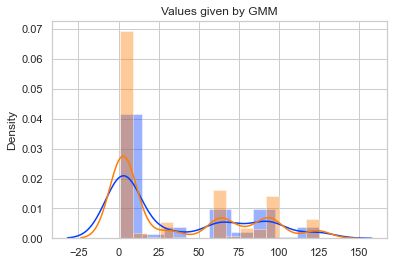

In [52]:
z22,_ = best_gmm22.sample(3190)
plt.title('Actual data')
sns.distplot(c)
#plt.show()
plt.title('Values given by GMM')
sns.distplot(z22)
plt.show()

In [53]:
wasserstein_distance(c.flatten(), z22.flatten())

0.20497678313015444

# Ceps and inverse ceps

In [87]:
from acoustics.cepstrum import complex_cepstrum
from acoustics.cepstrum import inverse_complex_cepstrum
duration = 250.0
fs = 1.0
samples = int(fs*duration)
t = np.arange(samples) / fs
ceps, _ = complex_cepstrum(signal_3['Value'])

In [80]:
ceps = np.flipud(ceps)
_

array(0.)

In [88]:
ceps

array([-1.68094268e-01,  2.74362230e-02,  1.58018616e-02,  3.21391046e-03,
       -8.84557899e-03, -1.90144814e-02, -2.62415957e-02, -2.99281863e-02,
       -2.99985439e-02, -2.68892414e-02, -2.14595761e-02, -1.48381052e-02,
       -8.23022335e-03, -2.71780521e-03,  9.16918073e-04,  2.31505400e-03,
        1.59258222e-03, -6.88396042e-04, -3.62389906e-03, -6.13083429e-03,
       -7.14185151e-03, -5.80055200e-03, -1.62509490e-03,  5.38688677e-03,
        1.47299328e-02,  2.54447282e-02,  3.62470734e-02,  4.57125208e-02,
        5.24883427e-02,  5.54999199e-02,  5.41192360e-02,  4.82688562e-02,
        3.84446741e-02,  2.56532824e-02,  1.12730921e-02, -3.13979778e-03,
       -1.60713588e-02, -2.62614039e-02, -3.28750065e-02, -3.56075287e-02,
       -3.47076147e-02, -3.09153464e-02, -2.53260336e-02, -1.92017247e-02,
       -1.37606562e-02, -9.97822596e-03, -8.43114576e-03, -9.20949690e-03,
       -1.19105756e-02, -1.57153658e-02, -1.95352786e-02, -2.22055226e-02,
       -2.26939143e-02, -

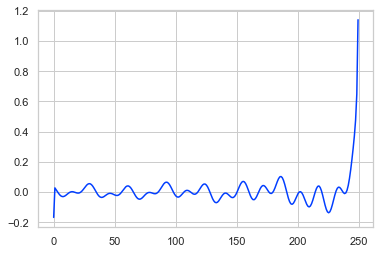

In [89]:
plt.plot(np.arange(250), ceps)

In [90]:
c1 = np.array(ceps).reshape(-1, 1)

In [62]:
dfx = c1
lowest_bic = np.infty
bic = []
n_components_range = range(1, 50)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(dfx)
        bic.append(gmm.bic(dfx))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm3 = gmm

In [63]:
print(best_gmm3, '\n')
print('WEIGHTS -', best_gmm3.weights_, '\n')
print('MEANS (Col 1: Freq; Col 2: Amplitude) - \n', best_gmm3.means_, '\n')

GaussianMixture(covariance_type='tied', n_components=5) 

WEIGHTS - [0.98403091 0.004      0.004      0.004      0.00396909] 

MEANS (Col 1: Freq; Col 2: Amplitude) - 
 [[8.08578358e-06]
 [3.67879441e-01]
 [6.76676416e-02]
 [1.65956895e-02]
 [4.57858563e-03]] 



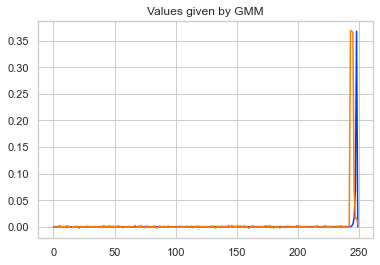

In [64]:
z3,_ = best_gmm3.sample(250)
plt.title('Actual data')
sns.lineplot(np.arange(250), ceps)
#plt.show()
plt.title('Values given by GMM')
sns.lineplot(np.arange(250),z3.flatten())
plt.show()

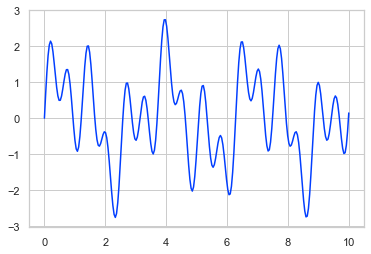

In [92]:
#c2 = z3.flatten()
#c2 = np.flipud(c2)
incep = inverse_complex_cepstrum(ceps, np.array(1.0))    # inverse ceps
plt.plot(signal_3['Time'], incep)
#plt.plot(signal_3["Time"], signal_3['Value'])
plt.show()

In [150]:
sample_1 = pd.DataFrame(zip(z3[:,0],z3[:,1]),columns=['Que','Cepstrum'])           
sample_1.Que = sample_1.Que.apply(lambda x:round(x,1))

In [137]:
a = np.arange(251)
a = a[1:]
a = list(map('{:.2f}'.format,a))
a = list(map(double, a))
sd = dict(zip(a,np.zeros(250)))

NameError: name 'double' is not defined

In [159]:
a = np.arange(251)
a = a[1:]
a = a*1.00
sd = dict(zip(a,np.zeros(250)))

In [160]:
samp_1 = dict(zip(sample_1.Que,sample_1.Cepstrum))

In [153]:
for i in samp_1.keys():
    if i in sd:
        sd[i] = samp_1[i]
        sd[-i] = samp_1[i]
    elif i+0.1 in sd:
        sd[i+0.1] = samp_1[i]
        sd[-(i+0.1)] = samp_1[i]
    elif i-0.1 in sd:
        sd[i-0.1] = samp_1[i]
        sd[-(i-0.1)] = samp_1[i]
sd

{1.0: 0.0,
 2.0: 0.3299583671324325,
 3.0: 0.17430627448798477,
 4.0: 0.07889271509225773,
 5.0: 0.1966535386763913,
 6.0: 0.0,
 7.0: 0.0,
 8.0: 0.04055622810039619,
 9.0: 0.0,
 10.0: 0.0,
 11.0: 0.0,
 12.0: 0.0,
 13.0: 0.0,
 14.0: 0.03487921368910706,
 15.0: 0.03525232494497105,
 16.0: 0.0,
 17.0: 0.0,
 18.0: 0.024748511518576023,
 19.0: 0.0,
 20.0: 0.02413031255559291,
 21.0: 0.020740391992350306,
 22.0: 0.02213814128380192,
 23.0: 0.019393539370036107,
 24.0: 0.018581918077439332,
 25.0: 0.01695350545383924,
 26.0: 0.017528288509419926,
 27.0: 0.01862951659376965,
 28.0: 0.017954800400295966,
 29.0: 0.0,
 30.0: 0.015522211575556178,
 31.0: 0.014839995749867942,
 32.0: 0.0,
 33.0: 0.0,
 34.0: 0.0,
 35.0: 0.0,
 36.0: 0.010712801273256736,
 37.0: 0.0,
 38.0: 0.0,
 39.0: 0.011365829462729638,
 40.0: 0.010613060407200281,
 41.0: 0.0,
 42.0: 0.0,
 43.0: 0.00872846897708845,
 44.0: 0.00864183218796189,
 45.0: 0.008133470474426543,
 46.0: 0.007711216275129522,
 47.0: 0.0,
 48.0: 0.0,
 49.0:

In [163]:
ceps

array([ 9.57439420e-01,  4.57899653e-01,  2.91841926e-01,  2.09252989e-01,
        1.60117079e-01,  1.27749965e-01,  1.04990175e-01,  8.82473384e-02,
        7.55187332e-02,  6.55962032e-02,  5.77058659e-02,  5.13280670e-02,
        4.61004618e-02,  4.17626064e-02,  3.81226506e-02,  3.50364400e-02,
        3.23939041e-02,  3.01098947e-02,  2.81178383e-02,  2.63652245e-02,
        2.48103270e-02,  2.34197759e-02,  2.21667308e-02,  2.10294878e-02,
        1.99904064e-02,  1.90350758e-02,  1.81516616e-02,  1.73303939e-02,
        1.65631612e-02,  1.58431898e-02,  1.51647886e-02,  1.45231463e-02,
        1.39141688e-02,  1.33343497e-02,  1.27806663e-02,  1.22504956e-02,
        1.17415474e-02,  1.12518087e-02,  1.07795002e-02,  1.03230396e-02,
        9.88101148e-03,  9.45214367e-03,  9.03528617e-03,  8.62939452e-03,
        8.23351552e-03,  7.84677523e-03,  7.46836871e-03,  7.09755136e-03,
        6.73363133e-03,  6.37596302e-03,  6.02394136e-03,  5.67699682e-03,
        5.33459092e-03,  

In [154]:
value = list(sd.values())

In [155]:
value = np.flipud(value)

ValueError: x and y must have same first dimension, but have shapes (250,) and (125, 2)

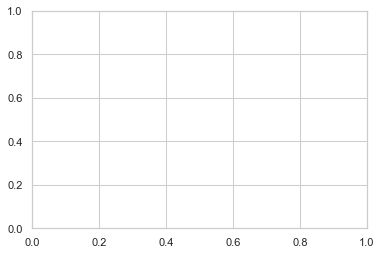

In [22]:
incep = inverse_complex_cepstrum(value, np.array(1.0))    # inverse ceps
plt.plot(signal_3['Time'], incep)
plt.show()

In [ ]:
a=np.arange(126)
a = a[1:]
b = a +   